In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance


In [2]:
def naive_roc_auc_score(y_true, y_pred):
  
  y_true = y_true.to_numpy()
  
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

score = make_scorer(naive_roc_auc_score, greater_is_better=True)

In [3]:
data = pd.read_csv('CP_Data.csv')
data = data.dropna()
features = data.loc[:, ['Molecular Weight', 'Heavy Atom Molecular Weight', 'Max Abs Partial Charge', 'Max Partial Charge', 
         'Min Abs Partial Charge', 'Min Partial Charge', 'Radical Electrons', 'Valence Electrons', 'NHOH Count', 'NO Count',
         'H Acceptors', 'H Donors', 'Ring Count', 'Aliphatic Rings', 'Aromatic Rings', 'Saturated Rings', 'Aromatic Carbocycles',
         'Aromatic Heterocycles', 'Heteroatoms', 'Rotatable Bonds', 'Saturated Carbocycles', 'Saturated Heterocycles', 'H Count',
         'C Count', 'N Count', 'F Count', 'Halogen Count', 'Double Bonds', 'Triple Bonds']]
list_numerical = features.columns

In [4]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-LUMO(eV)']
X = data.loc[:, ['Max Abs Partial Charge', 'Min Abs Partial Charge',
         'Aliphatic Rings', 'Heteroatoms', 'Rotatable Bonds', 'H Count', 'N Count']]
list_numerical = X.columns


# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              -LUMO(eV)   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              2929.
Date:                Fri, 03 Nov 2023   Prob (F-statistic):                        0.00
Time:                        13:30:24   Log-Likelihood:                         -793.22
No. Observations:                 780   AIC:                                      1600.
Df Residuals:                     773   BIC:                                      1633.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Max Abs Partial Charge     2.0409      0.196     10.419      0.000       1.656       2.425
Min Abs Partial Charge     3.7581      0.392      9.595      0.000       2.989       4.527
Aliphatic Rings           -0.1031      0.031     -3.302      0.001      -0.164      -0.042
Heteroatoms                0.0521      0.012      4.473      0.000       0.029       0.075
Rotatable Bonds           -0.0894      0.008    -11.224      0.000      -0.105      -0.074
H Count                    0.0477      0.003     13.778      0.000       0.041       0.054
N Count                    0.1534      0.021      7.336      0.000       0.112       0.194
==============================================================================
Omnibus:                       18.721   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.511
Skew:                           0.081   Prob(JB):                     1.18e-08
Kurtosis:                       4.048   Cond. No.                     1.75e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [5]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid, scoring=score, n_jobs=-1, cv=cv).fit(X_train, y_train)

print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_)
print("Train AUC ROC Score for GS: ", naive_roc_auc_score(y_train, grid_cv.predict(X_train)))
print("Test AUC ROC Score for GS: ",naive_roc_auc_score(y_test, grid_cv.predict(X_test)))

Param for GS {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
CV score for GS 0.6993854475412378
Train AUC ROC Score for GS:  0.9257682561775156
Test AUC ROC Score for GS:  0.7649145095548144


Mean Absolute Error: 0.17 eV.
R2:  0.44075341196229667
MSE:  0.054127441514736814
RMSE:  0.23265304965707373


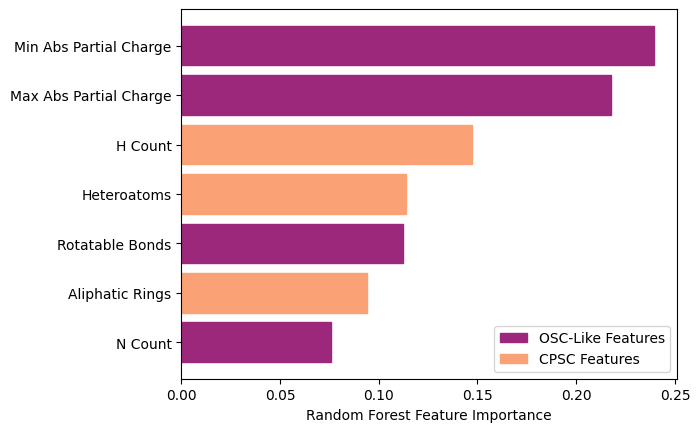

In [6]:
import matplotlib.patches as mpatches

rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

bars = plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
bars[0].set_color('#9B287B')
bars[1].set_color('#FAA275')
bars[2].set_color('#9B287B')
bars[3].set_color('#FAA275')
bars[4].set_color('#FAA275')
bars[5].set_color('#9B287B')
bars[6].set_color('#9B287B')
plt.xlabel("Random Forest Feature Importance")

both = mpatches.Patch(color='#9B287B', label='OSC-Like Features')
cp = mpatches.Patch(color='#FAA275', label='CPSC Features')
plt.legend(handles=[both, cp])

plt.rc('font', **font)


from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'eV.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)

In [7]:
count = 0

for i in data.loc[:, 'smiles']:
    if i.__contains__('N'):
        count += 1

print(count)

288


Mean Absolute Error: 0.15 degrees.
R2:  0.17946238319024477
MSE:  0.04707056244741563
RMSE:  0.2169575130006233


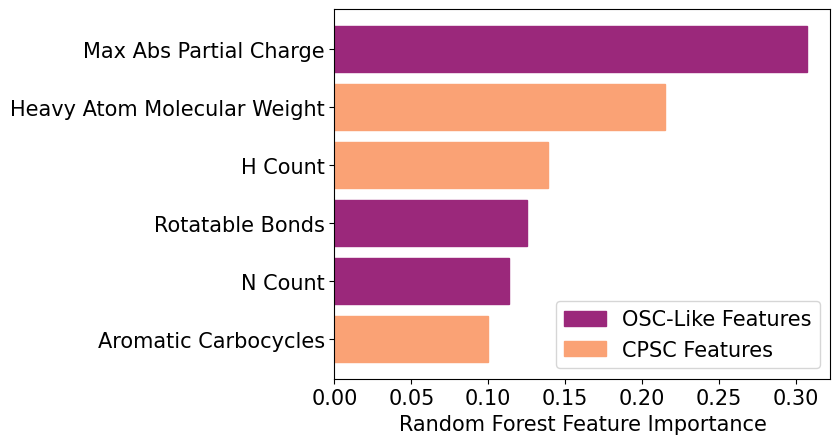

In [20]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
y = data['-HOMO(eV)']
X = data.loc[:, ['Heavy Atom Molecular Weight', 'Max Abs Partial Charge',
         'Aromatic Carbocycles', 'Rotatable Bonds', 'H Count', 'N Count']]
list_numerical = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

rfr = RandomForestRegressor(random_state=42, max_depth=15, min_samples_leaf=1, min_samples_split=5)
rfr.fit(X_train, y_train)

sorted_idx = rfr.feature_importances_.argsort()

bars = plt.barh(list_numerical[sorted_idx], rfr.feature_importances_[sorted_idx])
bars[0].set_color('#FAA275')
bars[1].set_color('#9B287B')
bars[2].set_color('#9B287B')
bars[3].set_color('#FAA275')
bars[4].set_color('#FAA275')
bars[5].set_color('#9B287B')
plt.xlabel("Random Forest Feature Importance")

both = mpatches.Patch(color='#9B287B', label='OSC-Like Features')
cp = mpatches.Patch(color='#FAA275', label='CPSC Features')
plt.legend(handles=[both, cp])

from sklearn.metrics import mean_squared_error

# Use the forest's predict method on the test data
predictions = rfr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

prediction = rfr.predict(X_test)
mse = mean_squared_error(y_test, prediction)
#calculate R-squared of regression model
r_squared = rfr.score(X_test, y_test)

#view R-squared value
print("R2: ", r_squared)
rmse = mse**.5
print("MSE: ", mse)
print("RMSE: ", rmse)